In [1]:
# Imports not from the google drive
# stdlib
import copy
import math
import os
import random
import sys

# external
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import tensorflow as tf
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

!pip install import_ipynb
# external
import import_ipynb

# Imports from the google drive
from google.colab import drive

drive.mount("/content/drive")

%cd /content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Noise Functions
file_dir = "/content/drive/Shared drives/Space Systems Divison/FINCH Mission/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Noise Functions"
sys.path.append(os.path.abspath(file_dir))
# external
import apply_stripes

%cd /content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models
file_dir = "/content/drive/Shared drives/Space Systems Divison/FINCH Mission/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models"
sys.path.append(os.path.abspath(file_dir))
# external
import noise_estimation

%cd /content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models/SURE CNN/Colab Notebooks/HSI_Denoising_SURE_CNN-master
file_dir = "/content/drive/Shared drives/Space Systems Divison/FINCH Mission/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models/SURE CNN/Colab Notebooks/HSI_Denoising_SURE_CNN-master"
sys.path.append(os.path.abspath(file_dir))
# external
from models.skipnet import *
from utils.common import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 13.1 MB/s 
Mounted at /content/drive
/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Noise Functions
importing Jupyter notebook from apply_stripes.ipynb
/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models
importing Jupyter notebook from noise_estimation.ipynb
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Destriping Models/SURE CNN/Colab Notebooks/HSI_Denoising_SURE_CNN-master


In [2]:
def import_indian_pines_data(to_import=True):
    """
    import Indian Pines dataset from Science Google Drive
    Args:
      import: if True import the dataset from Googel Drive, if false doesn't import
      To change the location of import to github

    Return: print statement of whether the dataset is imported properly or not
    """
    if to_import == True:
        # data get data to add stripe
        #!git clone https://github.com/spacesys-finch/Science #if says error uncomment this line
        # error cloning, so uploaded the data to google drive instead
        data = np.load(
            "/content/drive/Shareddrives/Space Systems Division/Teams/FINCH/Payload System/Science/Projects/SC-4: Data Processing/Destriping/Datasets/indian_pine_array.npy"
        )

        # changing from callibrated value to radiance
        # radiance_data_np = (data-1000)/500
        radiance_data_np = data.astype(np.float32)
        return radiance_data_np

In [3]:
# write a function for nomalizing the values in the numpy array


def normalize(numpy_arr_one, numpy_arr_two):
    """
    Normalize the values in numpy_arr_one and numpy_arr_two into values between -1 and 1
    Args:
      numpy_arr_one, numpy_arr_two: numpy arrays of the data to normalize
    Return: numpy_arr_one_norm, numpy_arr_two_norm: two arrays that are normalized
    """

    max_num = max(np.max(numpy_arr_one), np.max(numpy_arr_two))
    divisor = np.ones(numpy_arr_one.shape) * max_num
    numpy_arr_one_norm = np.divide(numpy_arr_one, divisor)
    numpy_arr_two_norm = np.divide(numpy_arr_two, divisor)
    return numpy_arr_one_norm, numpy_arr_two_norm, max_num

In [4]:
# reshape data to (1, data.shape[0], data.shape[1], data.shape[2])
def reshape(data):
    """
    Input: 3D Numpy array, Output: Reshaped 4D Numpy array
    Reshape HSI data from 3D to 4D to pass into CNN
    Ex. original data shape (20, 30, 40) will turn into (1, 20, 30, 40)
    """
    data_reshaped = data.reshape(1, data.shape[0], data.shape[1], data.shape[2])
    return data_reshaped

In [5]:
def define_model(striped_data):
    """
    Define the models and the necessary parameters of the model

    Args: None
    Return:
      mymodel: model of the defined properties
      lr: alpha value
      myoptimizer: optimizer of choice
      loss_object: type of loss object
    """
    # Define model
    mymodel = skip(ndown=5, channel=striped_data.shape[-1])
    lr = 0.001
    myoptimizer = tf.keras.optimizers.Adam(lr)
    loss_object = tf.keras.losses.MeanSquaredError()
    return mymodel, lr, myoptimizer, loss_object

In [6]:
# Calculate gradient
@tf.function
def grad(model, inputs, targets):
    sure = True
    with tf.GradientTape() as tape:
        loss_value, div_value = losshyper(
            model, inputs, targets, sigma=sigmaest, sure=sure
        )
    return loss_value, div_value, tape.gradient(loss_value, model.trainable_variables)

In [7]:
# function for calculating mean ssim (Structural Similarity Index)
def meanssim(X, Y):
    """
    Calculate the mean SSIM of the two images X and Y

    Args:
    x: first image to compare
    y: second image to compare with

    return
    np.mean(bandssim): mean similarity of the two images x and y
    """
    bandssim = []
    for i in range(X.shape[2]):
        bandssim.append(
            ssim(
                X[:, :, i],
                Y[:, :, i],
                data_range=1.0,
                K1=0.01,
                K2=0.03,
                gaussian_weights=True,
                sigma=1.5,
                use_sample_covariance=False,
            )
        )
    return np.mean(bandssim)

In [8]:
def train_model(train, model_file_path, striped_data, clean_data, num_epochs):
    """
    This function train the model and save the model

    Args:
      train: if true, train, if false not train
      model_file_path: filepath that the model is saved at
      striped_data: striped_data as numpy array with the shape (1, data.shape[0], data.shape[1], data.shape[2])
      clean_data: clean data as numpy array with the shape (1, data.shape[0], data.shape[1], data.shape[2])

    Return:
      train_loss_results: list of the training loss
      destriped_psnr: list of the psnr between the

    """
    if train == True:
        mymodel, lr, myoptimizer, loss_object = define_model(striped_data)
        sure = True
        # start training
        train_loss_results = []
        train_div_results = []
        destriped_psnr = []
        destriped_ssim = []
        curr_psnr = 0
        sure = True
        # for loop for going through each epoch
        for epoch in range(num_epochs):
            loss_label = "SURE"
            # get gradient for the current model
            loss_value, div_value, grads = grad(mymodel, striped_data, striped_data)
            # apply gradient to the optimizer
            myoptimizer.apply_gradients(zip(grads, mymodel.trainable_variables))
            img_out = mymodel.predict(striped_data)
            # if the pnsr between the clean image and the output from the model is higher than the previous output, save the current model
            if psnr(clean_data[0], img_out[0]) > curr_psnr:
                print("Saving Model")
                tf.keras.models.save_model(mymodel, model_file_path)
                curr_psnr = psnr(clean_data[0], img_out[0])
            curr_ssim = meanssim(clean_data[0], img_out[0])

            print("This is running epoch %d and Loss %f" % (epoch, loss_value))
            print("PSNR: " + str(curr_psnr))
            print("SSIM: " + str(curr_ssim))
            print(
                "Iteration %05d    Loss %f     PSNR %f    SSIM: "
                % (epoch, loss_value, curr_psnr),
                "\r",
                end="",
            )
            # updating loss, div, ssim
            train_loss_results.append(loss_value)
            train_div_results.append(div_value)
            destriped_psnr.append(curr_psnr)
            destriped_ssim.append(curr_ssim)

        return train_loss_results, destriped_psnr, destriped_ssim

    else:
        print("Does not train")
        return [0], [0]

In [9]:
def load_model_and_predict(filepath, striped_data):
    """
    This function load the saved model from the filepath and apply the model to striped_data to get the output

    Args:
      filepath: filepath that the model is saved in, the model should be of type .hdf5
      striped_data: striped_data in the format of numpy array with the shape (1, data.shape[0], data.shape[1], data.shape[2])

    Return:
      bestmodel: the model that is loaded from the filepath
      out_best: the output from passing striped_data into the loaded model
    """
    # set the model to load the trained model
    bestmodel = tf.keras.models.load_model(filepath)
    # pass the noisy image into the model to get the output from the trained model
    out_best = bestmodel.predict(striped_data)
    return bestmodel, out_best

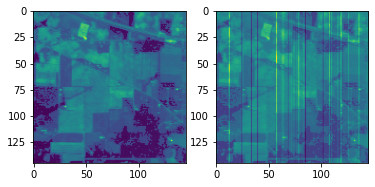

(200, 21025)   21025


In [10]:
# load data and add stripe/noise
ip_radiance_data_np = import_indian_pines_data()
ip_striped_data_np = ip_radiance_data_np
ip_radiance_data_np, ip_striped_data_np, factor = normalize(
    ip_radiance_data_np, ip_radiance_data_np
)
num_stripes = []

num_bands = 200  # number of bands in the HSI
num_of_stripes = 25  # number of stripes for each band

for i in range(num_bands):
    num_stripes.append(num_of_stripes)

# add stripes, change to other type of noise
ip_striped_data_np = apply_stripes.add_basic_stripes(ip_radiance_data_np, num_stripes)

# plot the striped images
band = 12
plt.subplot(121)
plt.imshow(np.clip(ip_radiance_data_np[:, :, band], 0, 1))
plt.subplot(122)
plt.imshow(np.clip(ip_striped_data_np[:, :, band], 0, 1))
plt.show()

# reshape radiance data and striped data
ip_radiance_data = reshape(ip_radiance_data_np)
ip_radiance_data = ip_radiance_data.astype(np.float32)
ip_striped_data = reshape(ip_striped_data_np)
ip_striped_data = ip_striped_data.astype(np.float32)

# calculate noise estimation
sigmaest = noise_estimation.noise_estimate(ip_radiance_data_np)
sigmaest = sigmaest.astype(np.float32)

(400, 200, 103)
(103, 80000)   80000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


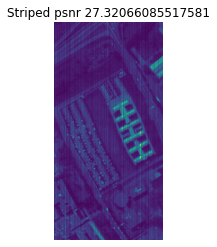

In [11]:
# load dataset, the one used is from Pavia University
dname = "sigma50eta0PaviaU"
fname = "hsi_data/Demo/" + dname + ".mat"
data = sio.loadmat(fname)

# create clean image numpy array of type float
img_clean_np = data["image"].astype(np.float32)
# get the shape of the dataset (400, 200, 103)
print(img_clean_np.shape)

# create noisy image numpy array of type float
img_striped_np = data["image"].astype(np.float32)

img_clean_np, img_striped_np, factor = normalize(img_clean_np, img_striped_np)

# add stripe using add_basic_stripes function
img_striped_np = apply_stripes.add_basic_stripes(img_striped_np).astype(np.float32)
# sigmaest = data["sigma2"].astype(np.float32) #estimated sigma by Wavelet (sigma2) or HySime (sigma1)
sigmaest = noise_estimation.noise_estimate(img_striped_np)
sigmaest = sigmaest.astype(np.float32)
# sigma=data['noiselev'].astype(np.float32) #True sigma (but unknow in practice)

# show the band 4
plt.imshow(np.clip(img_striped_np[:, :, 4], 0, 1))
# plt.imshow(img_clean_crop[:,:,showband])
plt.title("Striped psnr " + str(psnr(img_clean_np, img_striped_np)))
plt.axis("off")
plt.show()

# reshape the images to (1, 400, 200, 103)
img_striped = img_striped_np.reshape(
    1, img_striped_np.shape[0], img_striped_np.shape[1], img_striped_np.shape[2]
)
img_clean = img_clean_np.reshape(
    1, img_clean_np.shape[0], img_clean_np.shape[1], img_clean_np.shape[2]
)

In [12]:
# change filename of the model saved
filepath = "./results/best model/Demo/" + "sure" + "pavia_university_matlab" + ".hdf5"

In [ ]:
to_train = True
sure = True
num_epochs = 350
train_loss_results, destriped_psnr, destriped_ssim = train_model(
    to_train, filepath, img_striped, img_clean, num_epochs
)
PUbestmodel, out_best = load_model_and_predict(filepath, img_striped)

# show the output image
fig1, (ax, ax1, ax2) = plt.subplots(3, sharex=False, figsize=(6, 12))
ax.imshow(np.clip(out_best[0][:, :, band], 0, 1))
ax.set_title("Denoised  image, max PSNR=" + str(np.round(np.max(destriped_psnr), 2)))
ax.axis("off")
# plot train loss and divergence
ax1.plot(range(len(train_loss_results)), train_loss_results, label="train loss")
ax1.set_title("Training loss using SURE")
ax1.legend()
ax1.grid()

# plot PSNR
ax2.plot(destriped_psnr, label="destriped PSNR")
ax2.set_xlabel("Iterations")
ax2.set_title("PSNR using SURE")
ax2.legend()
ax2.grid()

1/1 [==============================] - 5s 5s/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


Saving Model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.


This is running epoch 0 and Loss 0.117752
PSNR: 9.981409024793777
SSIM: 0.2387539287128944
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 1 and Loss 0.101868
PSNR: 11.270908664104109
SSIM: 0.23561285523979505
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 2 and Loss 0.076411
PSNR: 12.519245983110247
SSIM: 0.2399321569715182
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 3 and Loss 0.057587
PSNR: 13.539397775780138
SSIM: 0.24330549582614464
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 4 and Loss 0.045912
PSNR: 14.789887729628255
SSIM: 0.2210483271511919
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 5 and Loss 0.035036
PSNR: 15.34141827160891
SSIM: 0.19977695042931473
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 6 and Loss 0.031278
PSNR: 15.732678823388763
SSIM: 0.2191292505247772
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 7 and Loss 0.028740
PSNR: 16.133026428890236
SSIM: 0.24813865468780721
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 8 and Loss 0.026303
PSNR: 16.388397150161147
SSIM: 0.2690400206872526
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 9 and Loss 0.024844
PSNR: 16.775614529710122
SSIM: 0.28150619503608204
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 10 and Loss 0.022894
PSNR: 17.161921449753816
SSIM: 0.30387474949205706
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 11 and Loss 0.021109
PSNR: 17.4403925410833
SSIM: 0.34036005538943126
1/1 [==============================] - 5s 5s/step
This is running epoch 12 and Loss 0.019875
PSNR: 17.4403925410833
SSIM: 0.31359488208880315
1/1 [==============================] - 6s 6s/step


Saving Model
This is running epoch 13 and Loss 0.020404
PSNR: 17.473650520808064
SSIM: 0.38471965102767947
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 14 and Loss 0.019715
PSNR: 18.127318312566565
SSIM: 0.3734129449178895
1/1 [==============================] - 5s 5s/step
This is running epoch 15 and Loss 0.017298
PSNR: 18.127318312566565
SSIM: 0.36539574310043627
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 16 and Loss 0.017421
PSNR: 18.497336951894624
SSIM: 0.41625030990682454
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 17 and Loss 0.015987
PSNR: 18.53114939638062
SSIM: 0.44212751100498887
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 18 and Loss 0.015840
PSNR: 18.87570941526483
SSIM: 0.4244552436006669
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 19 and Loss 0.014838
PSNR: 19.299446872328424
SSIM: 0.4532933695081107
1/1 [==============================] - 5s 5s/step
This is running epoch 20 and Loss 0.013618
PSNR: 19.299446872328424
SSIM: 0.4979163336873473
1/1 [==============================] - 6s 6s/step
This is running epoch 21 and Loss 0.015098
PSNR: 19.299446872328424
SSIM: 0.4223040997474457
1/1 [==============================] - 5s 5s/step
This is running epoch 22 and Loss 0.015446
PSNR: 19.299446872328424
SSIM: 0.46901694785173215
1/1 [==============================] - 5s 5s/step
This is running epoch 23 and Loss 0.013646
PSNR: 19.299446872328424
SSIM: 0.47505008342199145
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 24 and Loss 0.015216
PSNR: 19.661698417794582
SSIM: 0.49893495900285073
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 25 and Loss 0.012637
PSNR: 19.679730676730834
SSIM: 0.5002814581338821
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 26 and Loss 0.012637
PSNR: 20.377501893921504
SSIM: 0.5543222496775407
1/1 [==============================] - 6s 6s/step
This is running epoch 27 and Loss 0.011000
PSNR: 20.377501893921504
SSIM: 0.5802379968802631
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 28 and Loss 0.011733
PSNR: 20.553249737243995
SSIM: 0.5575506380633238
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 29 and Loss 0.010670
PSNR: 21.14462370556422
SSIM: 0.5946361135284984
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 30 and Loss 0.009518
PSNR: 21.147000444859614
SSIM: 0.614791937680788
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 31 and Loss 0.009462
PSNR: 21.447055466311017
SSIM: 0.6045552941133406
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 32 and Loss 0.008991
PSNR: 21.778714362608497
SSIM: 0.6261195726168175
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 33 and Loss 0.008431
PSNR: 22.03565124673682
SSIM: 0.631295851644978
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 34 and Loss 0.008059
PSNR: 22.26457525298233
SSIM: 0.6307177450085033
1/1 [==============================] - 7s 7s/step


Saving Model
This is running epoch 35 and Loss 0.007767
PSNR: 22.61277264083288
SSIM: 0.6494669834012736
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 36 and Loss 0.007278
PSNR: 22.77199863842041
SSIM: 0.6458265071329129
1/1 [==============================] - 5s 5s/step
This is running epoch 37 and Loss 0.007128
PSNR: 22.77199863842041
SSIM: 0.6581903692762547
1/1 [==============================] - 5s 5s/step
This is running epoch 38 and Loss 0.007911
PSNR: 22.77199863842041
SSIM: 0.5939954402952415
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 39 and Loss 0.010648
PSNR: 23.292389664058142
SSIM: 0.6680096534409092
1/1 [==============================] - 5s 5s/step
This is running epoch 40 and Loss 0.006497
PSNR: 23.292389664058142
SSIM: 0.6626888996707295
1/1 [==============================] - 5s 5s/step
This is running epoch 41 and Loss 0.007294
PSNR: 23.292389664058142
SSIM: 0.6241324140442673
1/1 [==============================] - 6s 6s/step
This is running epoch 42 and Loss 0.007902
PSNR: 23.292389664058142
SSIM: 0.6802433130862965
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 43 and Loss 0.006734
PSNR: 23.826539750057556
SSIM: 0.6868375867523131
1/1 [==============================] - 5s 5s/step
This is running epoch 44 and Loss 0.005950
PSNR: 23.826539750057556
SSIM: 0.6692605920480288
1/1 [==============================] - 6s 6s/step


Saving Model
This is running epoch 45 and Loss 0.006664
PSNR: 24.15516070812663
SSIM: 0.69986459471834
1/1 [==============================] - 5s 5s/step
This is running epoch 46 and Loss 0.005634
PSNR: 24.15516070812663
SSIM: 0.7020307725221925
1/1 [==============================] - 5s 5s/step
This is running epoch 47 and Loss 0.005930
PSNR: 24.15516070812663
SSIM: 0.6736750439208742
1/1 [==============================] - 7s 7s/step


Saving Model
This is running epoch 48 and Loss 0.006701
PSNR: 24.61797160025668
SSIM: 0.7102749722806975
1/1 [==============================] - 5s 5s/step
This is running epoch 49 and Loss 0.005234
PSNR: 24.61797160025668
SSIM: 0.7144163256475679
1/1 [==============================] - 5s 5s/step
This is running epoch 50 and Loss 0.005486
PSNR: 24.61797160025668
SSIM: 0.6997538623025894
1/1 [==============================] - 6s 6s/step


Saving Model
This is running epoch 51 and Loss 0.005765
PSNR: 25.110786570810607
SSIM: 0.7207827718419365
1/1 [==============================] - 5s 5s/step
This is running epoch 52 and Loss 0.004904
PSNR: 25.110786570810607
SSIM: 0.7226869473806193
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 53 and Loss 0.005406
PSNR: 25.442896994966482
SSIM: 0.727023924408956
1/1 [==============================] - 5s 5s/step
This is running epoch 54 and Loss 0.004666
PSNR: 25.442896994966482
SSIM: 0.7185586231350202
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 55 and Loss 0.005077
PSNR: 25.78563523190738
SSIM: 0.7363985155653445
1/1 [==============================] - 5s 5s/step
This is running epoch 56 and Loss 0.004424
PSNR: 25.78563523190738
SSIM: 0.7382541897930339
1/1 [==============================] - 5s 5s/step
This is running epoch 57 and Loss 0.004711
PSNR: 25.78563523190738
SSIM: 0.7333472023104294
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 58 and Loss 0.004501
PSNR: 25.952271540178646
SSIM: 0.7379649701322893
1/1 [==============================] - 5s 5s/step
This is running epoch 59 and Loss 0.004367
PSNR: 25.952271540178646
SSIM: 0.749106318288821
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 60 and Loss 0.004354
PSNR: 26.504224754903873
SSIM: 0.752361811308049
1/1 [==============================] - 5s 5s/step
This is running epoch 61 and Loss 0.004027
PSNR: 26.504224754903873
SSIM: 0.7484694597284969
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 62 and Loss 0.004232
PSNR: 26.648310579463015
SSIM: 0.7594726235387066
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 63 and Loss 0.003944
PSNR: 26.69353971502611
SSIM: 0.7616006823743032
1/1 [==============================] - 5s 5s/step
This is running epoch 64 and Loss 0.003923
PSNR: 26.69353971502611
SSIM: 0.7550240970929697
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 65 and Loss 0.004025
PSNR: 27.0220893301971
SSIM: 0.7655753679310399
1/1 [==============================] - 7s 7s/step
This is running epoch 66 and Loss 0.003769
PSNR: 27.0220893301971
SSIM: 0.7678918236866075
1/1 [==============================] - 5s 5s/step
This is running epoch 67 and Loss 0.003844
PSNR: 27.0220893301971
SSIM: 0.7587072589724699
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 68 and Loss 0.004021
PSNR: 27.116587565426308
SSIM: 0.7722389044148354
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 69 and Loss 0.003717
PSNR: 27.29849100986282
SSIM: 0.7741128504794996
1/1 [==============================] - 5s 5s/step
This is running epoch 70 and Loss 0.003647
PSNR: 27.29849100986282
SSIM: 0.7696993058039657
1/1 [==============================] - 5s 5s/step
This is running epoch 71 and Loss 0.003778
PSNR: 27.29849100986282
SSIM: 0.7784571967864594
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 72 and Loss 0.003693
PSNR: 27.509949618583317
SSIM: 0.7775043783335803
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 73 and Loss 0.003572
PSNR: 27.567341219161335
SSIM: 0.7798382151266186
1/1 [==============================] - 6s 6s/step
This is running epoch 74 and Loss 0.003546
PSNR: 27.567341219161335
SSIM: 0.7849801302787268
1/1 [==============================] - 5s 5s/step
This is running epoch 75 and Loss 0.003587
PSNR: 27.567341219161335
SSIM: 0.7824055602078336
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 76 and Loss 0.003569
PSNR: 27.738962515684108
SSIM: 0.7888213597465492
1/1 [==============================] - 5s 5s/step
This is running epoch 77 and Loss 0.003465
PSNR: 27.738962515684108
SSIM: 0.7910544868099874
1/1 [==============================] - 5s 5s/step
This is running epoch 78 and Loss 0.003459
PSNR: 27.738962515684108
SSIM: 0.7882457189739364
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 79 and Loss 0.003508
PSNR: 27.752547766724838
SSIM: 0.7946754634054037
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 80 and Loss 0.003446
PSNR: 27.995497607638328
SSIM: 0.7947672160778889
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 81 and Loss 0.003373
PSNR: 28.02491672707057
SSIM: 0.7956204900956819
1/1 [==============================] - 5s 5s/step
This is running epoch 82 and Loss 0.003369
PSNR: 28.02491672707057
SSIM: 0.7995643447572097
1/1 [==============================] - 5s 5s/step
This is running epoch 83 and Loss 0.003391
PSNR: 28.02491672707057
SSIM: 0.7971267501555924
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 84 and Loss 0.003385
PSNR: 28.079454821737627
SSIM: 0.8025969903349109
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 85 and Loss 0.003327
PSNR: 28.24222051352884
SSIM: 0.8027994107647918
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 86 and Loss 0.003284
PSNR: 28.307010159221303
SSIM: 0.8047035353343033
1/1 [==============================] - 5s 5s/step
This is running epoch 87 and Loss 0.003261
PSNR: 28.307010159221303
SSIM: 0.807610197625012
1/1 [==============================] - 6s 6s/step
This is running epoch 88 and Loss 0.003267
PSNR: 28.307010159221303
SSIM: 0.8048329378563277
1/1 [==============================] - 5s 5s/step
This is running epoch 89 and Loss 0.003307
PSNR: 28.307010159221303
SSIM: 0.8104573057142294
1/1 [==============================] - 5s 5s/step
This is running epoch 90 and Loss 0.003392
PSNR: 28.307010159221303
SSIM: 0.795321414000628
1/1 [==============================] - 5s 5s/step
This is running epoch 91 and Loss 0.003775
PSNR: 28.307010159221303
SSIM: 0.8091559674975609
1/1 [==============================] - 5s 5s/step
This is running epoch 92 and Loss 0.003773
PSNR: 28.307010159221303
SSIM: 0.800549098502005
1/1 [==============================] - 

Saving Model
This is running epoch 93 and Loss 0.003617
PSNR: 28.49594815097317
SSIM: 0.8126617887231976
1/1 [==============================] - 5s 5s/step
This is running epoch 94 and Loss 0.003195
PSNR: 28.49594815097317
SSIM: 0.8122155912203387
1/1 [==============================] - 5s 5s/step
This is running epoch 95 and Loss 0.003604
PSNR: 28.49594815097317
SSIM: 0.8041957332441496
1/1 [==============================] - 5s 5s/step
This is running epoch 96 and Loss 0.003512
PSNR: 28.49594815097317
SSIM: 0.8110841130098629
1/1 [==============================] - 5s 5s/step
This is running epoch 97 and Loss 0.003271
PSNR: 28.49594815097317
SSIM: 0.8142579057379696
1/1 [==============================] - 7s 7s/step


Saving Model
This is running epoch 98 and Loss 0.003598
PSNR: 28.52947751565006
SSIM: 0.8152168878777369
1/1 [==============================] - 5s 5s/step
This is running epoch 99 and Loss 0.003190
PSNR: 28.52947751565006
SSIM: 0.8100675523147017
1/1 [==============================] - 5s 5s/step
This is running epoch 100 and Loss 0.003404
PSNR: 28.52947751565006
SSIM: 0.8198242624610657
1/1 [==============================] - 5s 5s/step
This is running epoch 101 and Loss 0.003201
PSNR: 28.52947751565006
SSIM: 0.8208599170005829
1/1 [==============================] - 5s 5s/step
This is running epoch 102 and Loss 0.003253
PSNR: 28.52947751565006
SSIM: 0.8161953452711292
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 103 and Loss 0.003271
PSNR: 28.723030540696023
SSIM: 0.8210958352357383
1/1 [==============================] - 5s 5s/step
This is running epoch 104 and Loss 0.003128
PSNR: 28.723030540696023
SSIM: 0.8240277454693479
1/1 [==============================] - 7s 7s/step


Saving Model
This is running epoch 105 and Loss 0.003292
PSNR: 28.860704431599757
SSIM: 0.8240273467417347
1/1 [==============================] - 5s 5s/step
This is running epoch 106 and Loss 0.003082
PSNR: 28.860704431599757
SSIM: 0.8222309583778524
1/1 [==============================] - 5s 5s/step
This is running epoch 107 and Loss 0.003162
PSNR: 28.860704431599757
SSIM: 0.8282698760599713
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 108 and Loss 0.003130
PSNR: 28.99103480543615
SSIM: 0.8292241243795904
1/1 [==============================] - 5s 5s/step
This is running epoch 109 and Loss 0.003028
PSNR: 28.99103480543615
SSIM: 0.8256812362403549
1/1 [==============================] - 7s 7s/step


Saving Model
This is running epoch 110 and Loss 0.003121
PSNR: 29.015175095017156
SSIM: 0.8319674451978063
1/1 [==============================] - 5s 5s/step
This is running epoch 111 and Loss 0.003017
PSNR: 29.015175095017156
SSIM: 0.8333822165789214
1/1 [==============================] - 5s 5s/step
This is running epoch 112 and Loss 0.003021
PSNR: 29.015175095017156
SSIM: 0.8302085571123049
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 113 and Loss 0.003063
PSNR: 29.212460948227836
SSIM: 0.8357086221681989
1/1 [==============================] - 5s 5s/step
This is running epoch 114 and Loss 0.002964
PSNR: 29.212460948227836
SSIM: 0.8373851334913457
1/1 [==============================] - 7s 7s/step
This is running epoch 115 and Loss 0.002991
PSNR: 29.212460948227836
SSIM: 0.8345008068341827
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 116 and Loss 0.003021
PSNR: 29.31638221022196
SSIM: 0.839758784532136
1/1 [==============================] - 5s 5s/step
This is running epoch 117 and Loss 0.002931
PSNR: 29.31638221022196
SSIM: 0.8412858424442403
1/1 [==============================] - 5s 5s/step
This is running epoch 118 and Loss 0.002940
PSNR: 29.31638221022196
SSIM: 0.8387276267052858
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 119 and Loss 0.002980
PSNR: 29.365485989763233
SSIM: 0.8438643227729454
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 120 and Loss 0.002912
PSNR: 29.49848847710888
SSIM: 0.8448689023440931
1/1 [==============================] - 5s 5s/step
This is running epoch 121 and Loss 0.002882
PSNR: 29.49848847710888
SSIM: 0.8434693399142271
1/1 [==============================] - 5s 5s/step
This is running epoch 122 and Loss 0.002916
PSNR: 29.49848847710888
SSIM: 0.8476540300708597
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 123 and Loss 0.002897
PSNR: 29.64999272274412
SSIM: 0.8476075962438278
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 124 and Loss 0.002851
PSNR: 29.6894222412713
SSIM: 0.8488484011780061
1/1 [==============================] - 7s 7s/step
This is running epoch 125 and Loss 0.002841
PSNR: 29.6894222412713
SSIM: 0.8513214362037436
1/1 [==============================] - 5s 5s/step
This is running epoch 126 and Loss 0.002858
PSNR: 29.6894222412713
SSIM: 0.8498214992972927
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 127 and Loss 0.002858
PSNR: 29.69459915677222
SSIM: 0.8536893517091311
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 128 and Loss 0.002823
PSNR: 29.85920302973861
SSIM: 0.8540586733649433
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 129 and Loss 0.002794
PSNR: 29.895347455066567
SSIM: 0.8550374958962896
1/1 [==============================] - 5s 5s/step
This is running epoch 130 and Loss 0.002786
PSNR: 29.895347455066567
SSIM: 0.8572431643642816
1/1 [==============================] - 5s 5s/step
This is running epoch 131 and Loss 0.002794
PSNR: 29.895347455066567
SSIM: 0.855709873047732
1/1 [==============================] - 7s 7s/step
This is running epoch 132 and Loss 0.002810
PSNR: 29.895347455066567
SSIM: 0.8594941173438502
1/1 [==============================] - 5s 5s/step
This is running epoch 133 and Loss 0.002824
PSNR: 29.895347455066567
SSIM: 0.8559477818944387
1/1 [==============================] - 5s 5s/step
This is running epoch 134 and Loss 0.002861
PSNR: 29.895347455066567
SSIM: 0.8611424554703179
1/1 [==============================] - 5s 5s/step
This is running epoch 135 and Loss 0.002882
PSNR: 29.895347455066567
SSIM: 0.8555577505902132
1/1 [=========================

Saving Model
This is running epoch 137 and Loss 0.002874
PSNR: 29.905921619664284
SSIM: 0.8606168987533852
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 138 and Loss 0.002793
PSNR: 30.16704781437258
SSIM: 0.8649251210834893
1/1 [==============================] - 5s 5s/step
This is running epoch 139 and Loss 0.002710
PSNR: 30.16704781437258
SSIM: 0.8663080422648254
1/1 [==============================] - 5s 5s/step
This is running epoch 140 and Loss 0.002731
PSNR: 30.16704781437258
SSIM: 0.8634126835130221
1/1 [==============================] - 5s 5s/step
This is running epoch 141 and Loss 0.002789
PSNR: 30.16704781437258
SSIM: 0.8684340082020525
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 142 and Loss 0.002750
PSNR: 30.307550505709806
SSIM: 0.868035901033266
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 143 and Loss 0.002687
PSNR: 30.385909589452954
SSIM: 0.8697798341780976
1/1 [==============================] - 5s 5s/step
This is running epoch 144 and Loss 0.002665
PSNR: 30.385909589452954
SSIM: 0.8715484303549389
1/1 [==============================] - 5s 5s/step
This is running epoch 145 and Loss 0.002693
PSNR: 30.385909589452954
SSIM: 0.8693510953421377
1/1 [==============================] - 5s 5s/step
This is running epoch 146 and Loss 0.002723
PSNR: 30.385909589452954
SSIM: 0.8734986374259244
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 147 and Loss 0.002697
PSNR: 30.447375807048452
SSIM: 0.872687883092026
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 148 and Loss 0.002658
PSNR: 30.54097976133339
SSIM: 0.8754136383267136
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 149 and Loss 0.002621
PSNR: 30.588069570702785
SSIM: 0.8764113105167464
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 150 and Loss 0.002612
PSNR: 30.597651700007177
SSIM: 0.8760581970962854
1/1 [==============================] - 5s 5s/step
This is running epoch 151 and Loss 0.002623
PSNR: 30.597651700007177
SSIM: 0.8786751664039048
1/1 [==============================] - 5s 5s/step
This is running epoch 152 and Loss 0.002641
PSNR: 30.597651700007177
SSIM: 0.8761422182885679
1/1 [==============================] - 5s 5s/step
This is running epoch 153 and Loss 0.002671
PSNR: 30.597651700007177
SSIM: 0.8800728759422941
1/1 [==============================] - 5s 5s/step
This is running epoch 154 and Loss 0.002691
PSNR: 30.597651700007177
SSIM: 0.8757810185501615
1/1 [==============================] - 5s 5s/step
This is running epoch 155 and Loss 0.002746
PSNR: 30.597651700007177
SSIM: 0.881126506842022
1/1 [==============================] - 7s 7s/step
This is running epoch 156 and Loss 0.002745
PSNR: 30.597651700007177
SSIM: 0.8768945959736094
1/1 [=========================

Saving Model
This is running epoch 158 and Loss 0.002642
PSNR: 30.87816609507925
SSIM: 0.8834239960564598
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 159 and Loss 0.002559
PSNR: 30.919887482892303
SSIM: 0.8844807994330292
1/1 [==============================] - 5s 5s/step
This is running epoch 160 and Loss 0.002549
PSNR: 30.919887482892303
SSIM: 0.886267618144413
1/1 [==============================] - 5s 5s/step
This is running epoch 161 and Loss 0.002595
PSNR: 30.919887482892303
SSIM: 0.883688730208988
1/1 [==============================] - 5s 5s/step
This is running epoch 162 and Loss 0.002635
PSNR: 30.919887482892303
SSIM: 0.8878316600550865
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 163 and Loss 0.002591
PSNR: 30.987884150561385
SSIM: 0.8874887009102055
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 164 and Loss 0.002537
PSNR: 31.098740688708737
SSIM: 0.8893083199769519
1/1 [==============================] - 5s 5s/step
This is running epoch 165 and Loss 0.002504
PSNR: 31.098740688708737
SSIM: 0.890304483663304
1/1 [==============================] - 5s 5s/step
This is running epoch 166 and Loss 0.002515
PSNR: 31.098740688708737
SSIM: 0.8890752795213477
1/1 [==============================] - 5s 5s/step
This is running epoch 167 and Loss 0.002545
PSNR: 31.098740688708737
SSIM: 0.8916172482311013
1/1 [==============================] - 5s 5s/step
This is running epoch 168 and Loss 0.002551
PSNR: 31.098740688708737
SSIM: 0.8901768117104529
1/1 [==============================] - 5s 5s/step
This is running epoch 169 and Loss 0.002547
PSNR: 31.098740688708737
SSIM: 0.8932429444353434
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 170 and Loss 0.002515
PSNR: 31.235052133244857
SSIM: 0.892712230011215
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 171 and Loss 0.002487
PSNR: 31.276981832687177
SSIM: 0.8947519526549855
1/1 [==============================] - 6s 6s/step


Saving Model
This is running epoch 172 and Loss 0.002463
PSNR: 31.379860727567777
SSIM: 0.8952489392347154
1/1 [==============================] - 5s 5s/step


Saving Model
This is running epoch 173 and Loss 0.002450
PSNR: 31.42212836624474
SSIM: 0.8959731241328575
1/1 [==============================] - 5s 5s/step
This is running epoch 174 and Loss 0.002446
PSNR: 31.42212836624474
SSIM: 0.8972003601166483
1/1 [==============================] - 5s 5s/step
This is running epoch 175 and Loss 0.002450
PSNR: 31.42212836624474
SSIM: 0.8964473272633692
1/1 [==============================] - 5s 5s/step
This is running epoch 176 and Loss 0.002470
PSNR: 31.42212836624474
SSIM: 0.8978762818779825
1/1 [==============================] - 5s 5s/step
This is running epoch 177 and Loss 0.002526
PSNR: 31.42212836624474
SSIM: 0.8912789468826082
1/1 [==============================] - 5s 5s/step
This is running epoch 178 and Loss 0.002725
PSNR: 31.42212836624474
SSIM: 0.891721987097883
1/1 [==============================] - 5s 5s/step
This is running epoch 179 and Loss 0.003067
PSNR: 31.42212836624474
SSIM: 0.8637779603113226
1/1 [==============================] 

Saving Model
This is running epoch 195 and Loss 0.002599
PSNR: 31.698422832330955
SSIM: 0.9035515511054901
1/1 [==============================] - 5s 5s/step
This is running epoch 196 and Loss 0.002392
PSNR: 31.698422832330955
SSIM: 0.8993579811026836
1/1 [==============================] - 5s 5s/step
This is running epoch 197 and Loss 0.002523
PSNR: 31.698422832330955
SSIM: 0.9048319217876946
1/1 [==============================] - 5s 5s/step
This is running epoch 198 and Loss 0.002397
PSNR: 31.698422832330955
SSIM: 0.9040979733348861


In [15]:
PUbestmodel, out_best = load_model_and_predict(filepath, img_striped)

1/1 [==============================] - 4s 4s/step


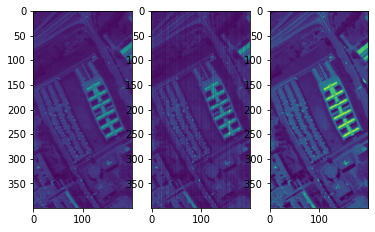

Original PSNR: 27.32066085517581
Destriped PSNR: 34.2926271723408


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  # This is added back by InteractiveShellApp.init_path()


In [22]:
# show the images (clean, noisy, output from the trained model)
band = 4
plt.subplot(131)
plt.imshow(np.clip(img_clean_np[:, :, band], 0, 1))
plt.subplot(132)
plt.imshow(np.clip(img_striped_np[:, :, band], 0, 1))
plt.subplot(133)
plt.imshow(np.clip(out_best[0][:, :, band], 0, 1))
plt.show()
print("Original PSNR: " + str(psnr(img_clean[0], img_striped[0])))
print("Destriped PSNR: " + str(psnr(img_clean[0], out_best[0])))